# Point Process Optimization with Kernel-Based Potentials

This notebook implements optimization of point configurations in a d-dimensional phase space using pair potentials defined by a kernel function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Core Classes and Functions

In [8]:
class PointProcessOptimizer:
    """Optimizer for point configurations using kernel-based pair potentials."""
    
    def __init__(self, d, n, minima=None, maxima=None, kernel=None):
        """
        Initialize the optimizer.
        
        Parameters:
        -----------
        d : int - Dimension of the phase space
        n : int - Number of points
        minima : array-like - Minimum values for each dimension (default: 0)
        maxima : array-like - Maximum values for each dimension (default: 1)
        kernel : callable - Kernel function K(r) (default: 1/r repulsive)
        """
        self.d = d
        self.n = n
        self.minima = np.zeros(d) if minima is None else np.array(minima)
        self.maxima = np.ones(d) if maxima is None else np.array(maxima)
        self.kernel = kernel if kernel else lambda r: 1.0 / (r + 1e-10)
        self.X_optimal = None
    
    def generate_random_points(self):
        """Generate n random uniform points in S."""
        X = np.random.uniform(size=(self.n, self.d))
        return X * (self.maxima - self.minima) + self.minima
    
    def compute_potential(self, X_flat):
        """Compute the total potential H(X)."""
        X = X_flat.reshape(self.n, self.d)
        distances = pdist(X)  # Pairwise Euclidean distances
        potentials = self.kernel(distances)
        return np.sum(potentials)
    
    def optimize(self, X_initial=None, method='L-BFGS-B', maxiter=1000):
        """Find configuration that minimizes potential."""
        if X_initial is None:
            X_initial = self.generate_random_points()
        
        # Set bounds
        bounds = [(self.minima[i % self.d], self.maxima[i % self.d]) 
                  for i in range(self.n * self.d)]
        
        result = minimize(
            self.compute_potential,
            X_initial.flatten(),
            method=method,
            bounds=bounds,
            options={'maxiter': maxiter, 'disp': False}
        )
        
        self.X_optimal = result.x.reshape(self.n, self.d)
        self.optimization_result = result
        return self.X_optimal
    
    def plot_configuration(self, X=None, title='Point Configuration'):
        """Plot the point configuration."""
        if X is None:
            X = self.X_optimal
        if X is None:
            raise ValueError("No configuration to plot. Run optimize() first.")
        
        if self.d == 1:
            fig, ax = plt.subplots(figsize=(12, 3))
            ax.scatter(X[:, 0], np.zeros(self.n), s=100, c='royalblue', edgecolors='navy')
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.set_xlim(self.minima[0] - 0.1, self.maxima[0] + 0.1)
            ax.set_ylim(-0.5, 0.5)
            ax.set_xlabel('x', fontsize=12)
            ax.set_title(title, fontsize=14)
            ax.set_yticks([])
            plt.tight_layout()
            plt.show()
            return fig
            
        elif self.d == 2:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.scatter(X[:, 0], X[:, 1], s=100, c='royalblue', edgecolors='navy')
            ax.set_xlim(self.minima[0] - 0.1, self.maxima[0] + 0.1)
            ax.set_ylim(self.minima[1] - 0.1, self.maxima[1] + 0.1)
            ax.set_xlabel('x₁', fontsize=12)
            ax.set_ylabel('x₂', fontsize=12)
            ax.set_title(title, fontsize=14)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            return fig
            
        elif self.d == 3:
            # Use Plotly for interactive 3D
            # Create edges of the parallelepiped S
            x0, y0, z0 = self.minima
            x1, y1, z1 = self.maxima
            # Define all 12 edges of the parallelepiped as line segments
            edges_x = [x0, x1, None, x0, x1, None, x0, x1, None, x0, x1, None,  # edges along x
                    x0, x0, None, x1, x1, None, x0, x0, None, x1, x1, None,  # edges along y
                    x0, x0, None, x1, x1, None, x0, x0, None, x1, x1, None]  # edges along z
            edges_y = [y0, y0, None, y1, y1, None, y0, y0, None, y1, y1, None,
                    y0, y1, None, y0, y1, None, y0, y1, None, y0, y1, None,
                    y0, y0, None, y0, y0, None, y1, y1, None, y1, y1, None]
            edges_z = [z0, z0, None, z0, z0, None, z1, z1, None, z1, z1, None,
                    z0, z0, None, z0, z0, None, z1, z1, None, z1, z1, None,
                    z0, z1, None, z0, z1, None, z0, z1, None, z0, z1, None]
            fig = go.Figure(data=[go.Scatter3d(
                x=X[:, 0], y=X[:, 1], z=X[:, 2],
                mode='markers',
                marker=dict(
                    size=8,
                    color='royalblue',
                    line=dict(color='navy', width=1)
                )
            )])
            fig.update_layout(
                title=f'{title} (drag to rotate)',
                scene=dict(
                    xaxis_title='x₁',
                    yaxis_title='x₂',
                    zaxis_title='x₃'
                ),
                width=700,
                height=600
            )
            fig.show()
            return fig
        else:
            print(f"Cannot plot {self.d}-dimensional configuration directly.")
            return None
        
    

## 2. Diagnostic Functions

In [3]:
class PointProcessDiagnostics:
    """Diagnostic functions for point configurations."""
    
    def __init__(self, X, minima=None, maxima=None):
        self.X = np.array(X)
        self.n, self.d = self.X.shape
        self.minima = np.zeros(self.d) if minima is None else np.array(minima)
        self.maxima = np.ones(self.d) if maxima is None else np.array(maxima)
        self.volume = np.prod(self.maxima - self.minima)
        self.intensity = self.n / self.volume
    
    def ripley_k_function(self, r_values=None, n_r=50):
        """Compute Ripley's K-function."""
        if r_values is None:
            max_r = np.min(self.maxima - self.minima) / 2
            r_values = np.linspace(0, max_r, n_r)
        
        distances = squareform(pdist(self.X))
        K_values = np.zeros(len(r_values))
        
        for i, r in enumerate(r_values):
            count = np.sum(distances < r) - self.n  # Exclude diagonal
            K_values[i] = (self.volume / (self.n * (self.n - 1))) * count
        
        return r_values, K_values
    
    def contact_distribution(self, r_values=None, n_samples=1000, n_r=50):
        """Compute contact distribution function F(r)."""
        if r_values is None:
            max_r = np.min(self.maxima - self.minima) / 4
            r_values = np.linspace(0, max_r, n_r)
        
        # Generate random sample points
        samples = np.random.uniform(size=(n_samples, self.d))
        samples = samples * (self.maxima - self.minima) + self.minima
        
        # Min distance from each sample to configuration points
        min_distances = cdist(samples, self.X).min(axis=1)
        
        F_values = np.array([np.mean(min_distances <= r) for r in r_values])
        return r_values, F_values
    
    def nearest_neighbour_distribution(self, r_values=None, n_r=50):
        """Compute nearest-neighbour distribution G(r): 
        empirical CDF of distances from each point to its nearest neighbour."""
        if r_values is None:
            max_r = np.min(self.maxima - self.minima) / 4
            r_values = np.linspace(0, max_r, n_r)
    
        # Compute pairwise distances
        distances = squareform(pdist(self.X))
        # Set diagonal to infinity to exclude self-distances
        np.fill_diagonal(distances, np.inf)
        # Get nearest neighbour distance for each point
        nn_distances = distances.min(axis=1)
        # Compute empirical CDF
        G_values = np.array([np.mean(nn_distances <= r) for r in r_values])
        return r_values, G_values
    
    def plot_all_diagnostics(self):
        """Plot all diagnostic functions."""
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # K-function
        r, K = self.ripley_k_function()
        axes[0].plot(r, K, 'b-', linewidth=2, label='K(r)')
        if self.d == 2:
            axes[0].plot(r, np.pi * r**2, 'r--', label='πr² (Poisson)')
        axes[0].set_xlabel('r')
        axes[0].set_ylabel('K(r)')
        axes[0].set_title("Ripley's K-function")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Contact distribution
        r, F = self.contact_distribution()
        axes[1].plot(r, F, 'b-', linewidth=2, label='F(r)')
        axes[1].set_xlabel('r')
        axes[1].set_ylabel('F(r)')
        axes[1].set_title('Contact Distribution F(r)')
        axes[1].grid(True, alpha=0.3)

        # Nearest-neighbour distribution
        r, G = self.nearest_neighbour_distribution()
        axes[2].plot(r, G, 'b-', linewidth=2, label='G(r)')
        if self.d == 2:
            # Theoretical G for Poisson: G(r) = 1 - exp(-λπr²)
            axes[2].plot(r, 1 - np.exp(-self.intensity * np.pi * r**2), 'r--', label='Poisson') 
            axes[2].set_xlabel('r')
            axes[2].set_ylabel('G(r)')
            axes[2].set_title('Nearest-Neighbour Distribution G(r)')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        return fig

## 3. Example: 2D Optimization

In [ ]:
# Define a repulsive kernel (Coulomb-like)
kernel_repulsive = lambda r: 1.0 / (r + 1e-8)

# Create optimizer for 2D with 20 points
opt_2d = PointProcessOptimizer(d=2, n=20, kernel=kernel_repulsive)

# Generate initial random configuration
X_init = opt_2d.generate_random_points()
print(f"Initial potential: {opt_2d.compute_potential(X_init.flatten()):.4f}")

# Optimize
X_opt = opt_2d.optimize(X_init)
print(f"Optimized potential: {opt_2d.compute_potential(X_opt.flatten()):.4f}")

Initial potential: 508.3250
Optimized potential: 328.3245


In [ ]:

# Generate initial random configuration
X_init = opt_2d.generate_random_points()
print(f"Initial potential: {opt_2d.compute_potential(X_init.flatten()):.4f}")

# Optimize
X_opt = opt_2d.optimize(X_init)
print(f"Optimized potential: {opt_2d.compute_potential(X_opt.flatten()):.4f}")

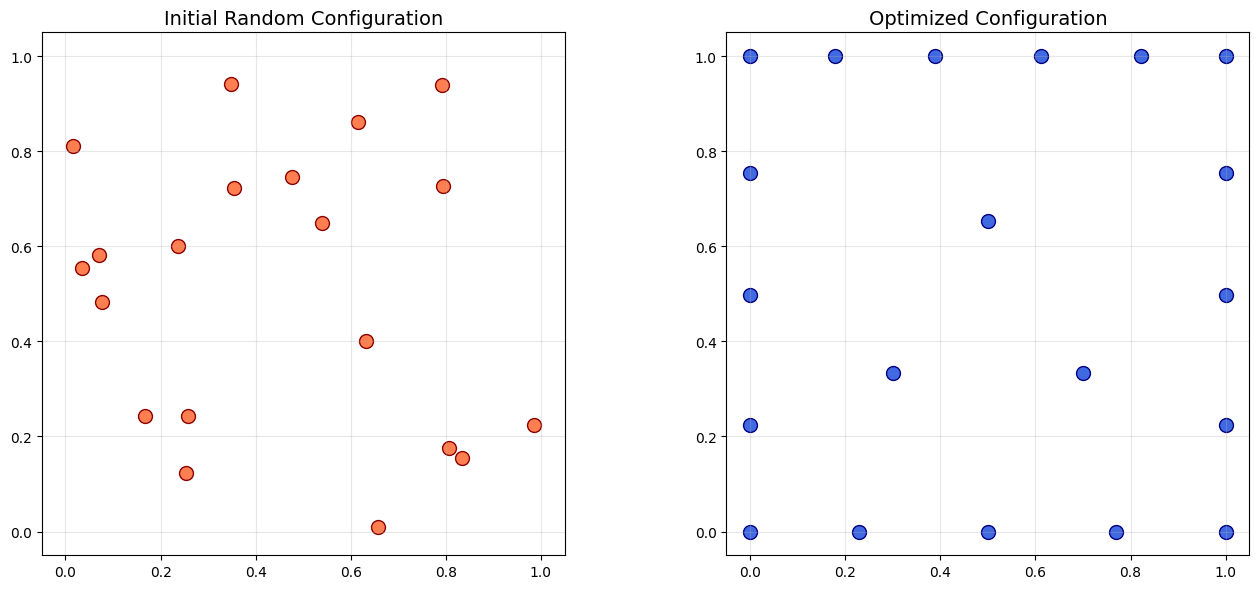

In [5]:
# Plot before and after
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_init[:, 0], X_init[:, 1], s=100, c='coral', edgecolors='darkred')
axes[0].set_title('Initial Random Configuration', fontsize=14)
axes[0].set_xlim(-0.05, 1.05)
axes[0].set_ylim(-0.05, 1.05)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X_opt[:, 0], X_opt[:, 1], s=100, c='royalblue', edgecolors='navy')
axes[1].set_title('Optimized Configuration', fontsize=14)
axes[1].set_xlim(-0.05, 1.05)
axes[1].set_ylim(-0.05, 1.05)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

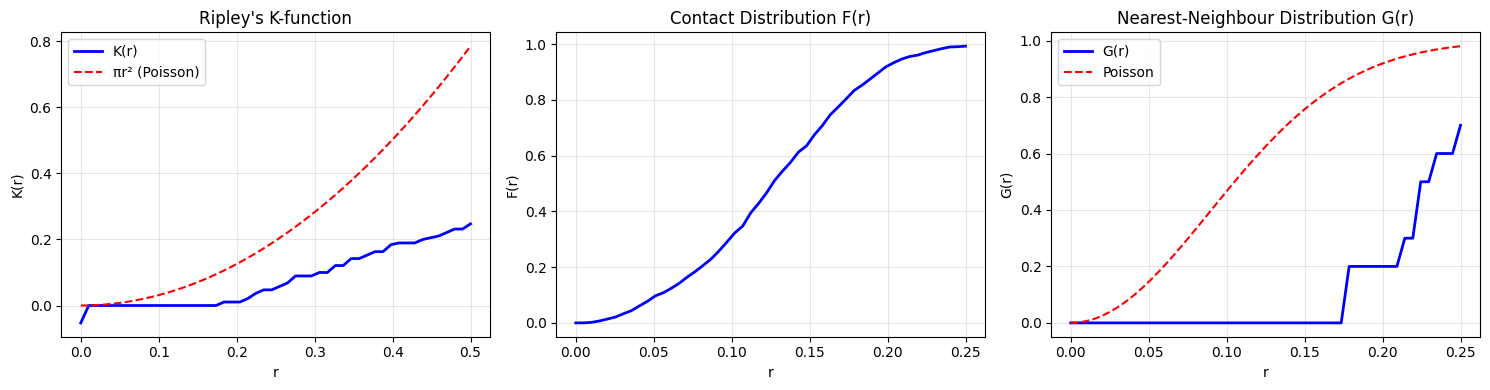

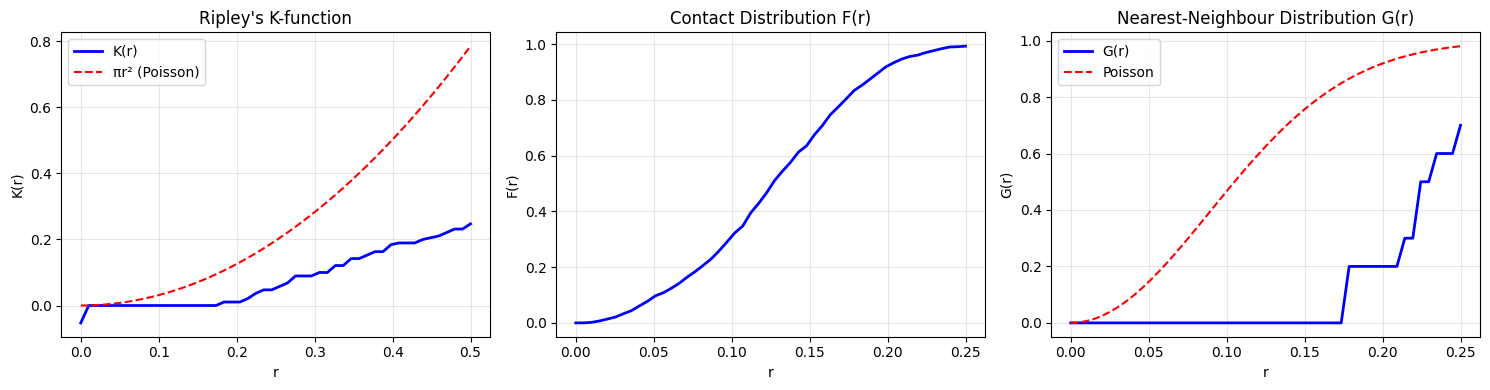

In [12]:
# Compute diagnostics for optimized configuration
diag_2d = PointProcessDiagnostics(X_opt)
diag_2d.plot_all_diagnostics()

## 4. Example: 1D Optimization

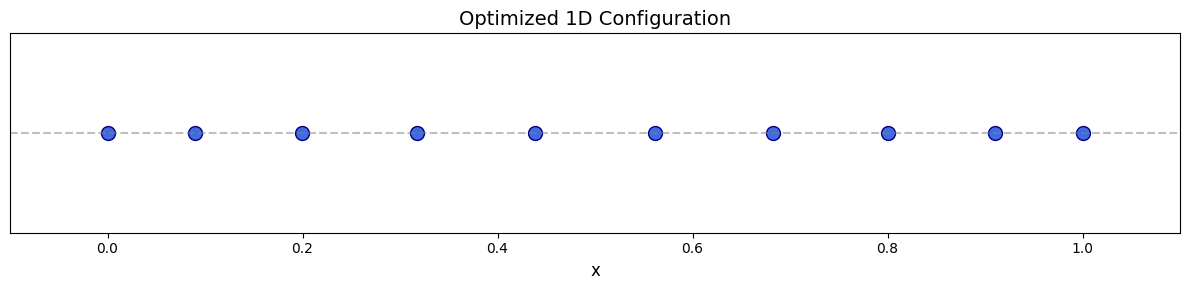

Optimal positions: [0.         0.09025422 0.1999351  0.31751222 0.43879909 0.56120163
 0.68248818 0.80006525 0.90974585 1.        ]


In [6]:
opt_1d = PointProcessOptimizer(d=1, n=10, kernel=kernel_repulsive)
X_opt_1d = opt_1d.optimize()
opt_1d.plot_configuration(title='Optimized 1D Configuration')
print(f"Optimal positions: {np.sort(X_opt_1d.flatten())}")

## 5. Example: 3D Interactive Optimization

In [9]:
opt_3d = PointProcessOptimizer(d=3, n=15, kernel=kernel_repulsive)
X_opt_3d = opt_3d.optimize()
print(f"Optimized 3D potential: {opt_3d.compute_potential(X_opt_3d.flatten()):.4f}")
opt_3d.plot_configuration(title='Optimized 3D Configuration')

Optimized 3D potential: 106.3745


In [ ]:
# 3D Diagnostics
diag_3d = PointProcessDiagnostics(X_opt_3d)
diag_3d.plot_all_diagnostics()

## 6. Custom Kernel Examples

In [ ]:
# Lennard-Jones like kernel (repulsive at short range, attractive at long)
kernel_lj = lambda r: (1/(r+0.1))**12 - 2*(1/(r+0.1))**6

# Gaussian kernel
kernel_gauss = lambda r: np.exp(-r**2 / 0.1)

# Test with Gaussian kernel
opt_gauss = PointProcessOptimizer(d=2, n=25, kernel=kernel_gauss)
X_gauss = opt_gauss.optimize()
opt_gauss.plot_configuration(title='Gaussian Kernel - Optimized 2D')

## 7. Custom Bounds Example

In [ ]:
# Rectangular domain
opt_rect = PointProcessOptimizer(
    d=2, n=30,
    minima=[0, 0],
    maxima=[2, 1],
    kernel=kernel_repulsive
)
X_rect = opt_rect.optimize()
opt_rect.plot_configuration(title='Rectangular Domain [0,2]×[0,1]')